# Asset-class tickers used in this notebook

**Equities (with dividend reinvestment):**
- **Sweden**: EWD — iShares Sweden MSCI ETF (Swedish equities, reinvests dividends; EXS1/OMX30 is delisted)
- **USA**: SPY — SPDR S&P 500 ETF Trust (US large-cap, S&P 500 index, reinvests dividends)
- **Emerging**: VWO — Vanguard FTSE Emerging Markets ETF (emerging markets equities, reinvests dividends)

**Commodities:**
- **Gold**: GLD — SPDR Gold Shares (gold bullion proxy)

**REITs:**
- **REITs**: VNQ — Vanguard Real Estate ETF (US real estate investment trusts)

**Bonds (duration/maturity in name):**
- **Bonds (Short)**: SHV — iShares 1-3 Year Treasury Bond ETF (short-duration US treasuries, ~1-3 years)
- **Bonds (Long)**: TLT — iShares 20+ Year Treasury Bond ETF (long-duration US treasuries, 20+ years)
- **Bonds (EU Alt)**: EUNL — iShares Euro Corporate Bonds ETF (European corporate bonds, medium duration)

All equity indices assume full dividend reinvestment. Bond duration/maturity range is noted in parentheses.

---------------------------------
Changes to Add:
- Cash earning normal interest

In [102]:
# Notebook parameters — change these to adjust asset classes and time period
# `TICKERS` can be modified to test different asset-class mappings.
# `START_DATE` and `END_DATE` control the backtest date range.
# All equities reinvest dividends. Bonds have duration/maturity noted.
# Note: EXS1 (OMX30) was delisted; using EWD (Swedish MSCI) instead
# Example configurations:
#   - Long-term US bonds: {"Bonds_Short": "SHV", "Bonds_Long": "TLT"}
#   - European bonds: {"Bonds": "EUNL"}
DEFAULT_TICKERS_EXT = {
    "Sweden": "EWD", 
    "USA_SP500": "SPY", 
    "Emerging": "VWO", 
    "Gold": "GLD", 
    "Bonds_Short_1-3Y": "SHV",
    "Bonds_Long_20Y": "TLT",
    "REITs": "VNQ"
}
TICKERS = DEFAULT_TICKERS_EXT.copy()
START_DATE = "2023-01-01"  # Test period: 2023-2025
END_DATE = "2025-12-31"    # Set to None to use all data; change to test specific periods
NUM_PORTFOLIOS = 2000
SEED = 42
SAVE_DIR = "results"
import os
os.makedirs(SAVE_DIR, exist_ok=True)
print('TICKERS:', TICKERS)
print('START_DATE:', START_DATE)
print('END_DATE:', END_DATE)
print('NUM_PORTFOLIOS:', NUM_PORTFOLIOS)

TICKERS: {'Sweden': 'EWD', 'USA_SP500': 'SPY', 'Emerging': 'VWO', 'Gold': 'GLD', 'Bonds_Short_1-3Y': 'SHV', 'Bonds_Long_20Y': 'TLT', 'REITs': 'VNQ'}
START_DATE: 2023-01-01
END_DATE: 2025-12-31
NUM_PORTFOLIOS: 2000


In [97]:
# Helper functions defined inline so the notebook is self-contained
from typing import Dict, Optional
import pandas as pd
import numpy as np
import yfinance as yf

TRADING_DAYS = 252

def fetch_prices(tickers: Dict[str, str], start: str, end: Optional[str] = None) -> pd.DataFrame:
    yf_tickers = list(tickers.values())
    data = yf.download(yf_tickers, start=start, end=end, progress=False, auto_adjust=False)
    if data.empty:
        raise RuntimeError("No data fetched. Check tickers or date range.")
    adj = data["Adj Close"].copy()
    if isinstance(adj, pd.Series):
        adj = adj.to_frame(adj.name)
    mapping = {tickers[k]: k for k in tickers}
    adj = adj.rename(columns=mapping)
    adj = adj.sort_index()
    return adj

def compute_returns(prices: pd.DataFrame, method: str = "log") -> pd.DataFrame:
    if method == "log":
        return np.log(prices / prices.shift(1)).dropna()
    else:
        return prices.pct_change().dropna()

def apply_annual_fees(returns: pd.DataFrame, annual_fees: Dict[str, float]) -> pd.DataFrame:
    daily_fees = {k: (1 + v) ** (1 / TRADING_DAYS) - 1 for k, v in annual_fees.items()}
    net = returns.copy()
    for col in net.columns:
        fee = daily_fees.get(col, 0.0)
        net[col] = net[col] - fee
    return net

def apply_isk_simple_tax_on_annual(values: pd.Series, annual_tax_rate: float) -> pd.Series:
    vals = values.copy()
    yrs = vals.index.year
    year_ends = vals.groupby(yrs).apply(lambda s: s.index[-1])
    for idx in year_ends:
        tax_base = vals.loc[idx]
        vals.loc[idx:] = vals.loc[idx:] - (annual_tax_rate * tax_base)
    return vals

def portfolio_return_series(returns: pd.DataFrame, weights: Dict[str, float]) -> pd.Series:
    cols = list(weights.keys())
    w = np.array([weights[c] for c in cols])
    rets = returns[cols].dot(w)
    return rets

def cagr_from_value_series(values: pd.Series) -> float:
    days = (values.index[-1] - values.index[0]).days
    years = days / 365.25
    return (values.iloc[-1] / values.iloc[0]) ** (1 / years) - 1

def max_drawdown(values: pd.Series) -> float:
    cum = values / values.iloc[0]
    roll_max = cum.cummax()
    dd = (cum / roll_max) - 1
    return dd.min()

def annualized_vol(returns: pd.Series) -> float:
    return returns.std() * np.sqrt(TRADING_DAYS)

def sharpe_ratio(returns: pd.Series, risk_free: float = 0.0) -> float:
    ann_ret = returns.mean() * TRADING_DAYS
    ann_vol = annualized_vol(returns)
    return (ann_ret - risk_free) / ann_vol if ann_vol != 0 else np.nan

def portfolio_metrics_from_returns(portfolio_rets: pd.Series, start_value: float = 1.0, risk_free: float = 0.0) -> Dict[str, float]:
    values = (1 + portfolio_rets).cumprod() * start_value
    return {
        "CAGR": cagr_from_value_series(values),
        "AnnualVol": annualized_vol(portfolio_rets),
        "Sharpe": sharpe_ratio(portfolio_rets, risk_free),
        "MaxDrawdown": max_drawdown(values)
    }

In [103]:
# Fetch prices and show head
# Use the ticker mapping from the parameters cell
tickers = TICKERS
prices = fetch_prices(tickers, start=START_DATE, end=END_DATE)
prices.head()

Ticker,Sweden,Gold,Bonds_Short_1-3Y,USA_SP500,Bonds_Long_20Y,REITs,Emerging
Date,,,,,,,
2023-01-03,30.342474,171.059998,95.738777,366.069092,90.171227,73.179764,35.804245
2023-01-04,30.899214,172.669998,95.747490,368.895203,91.406563,74.837303,36.731152
2023-01-05,30.518772,170.520004,95.764893,364.684814,91.788712,72.825211,36.622105
2023-01-06,31.391005,173.710007,95.782295,373.047791,93.477310,74.784119,37.249142
2023-01-09,31.947746,174.100006,95.791008,372.836334,93.975006,74.810707,37.449051


In [104]:
# Compute returns, apply fees and compute portfolio metrics
returns = compute_returns(prices, method="simple")
# Example annual fees (expense ratios) for the ETF proxies
fees = {
    "Sweden": 0.003, 
    "USA_SP500": 0.0009, 
    "Emerging": 0.003, 
    "Gold": 0.004, 
    "Bonds_Short_1-3Y": 0.0004,
    "Bonds_Long_20Y": 0.0020,
    "REITs": 0.0012
}
net_returns = apply_annual_fees(returns, fees)
# Example weights (must match keys in DEFAULT_TICKERS_EXT)
weights = {
    "Sweden": 0.10, 
    "USA_SP500": 0.40, 
    "Emerging": 0.10, 
    "Gold": 0.10, 
    "Bonds_Short_1-3Y": 0.10,
    "Bonds_Long_20Y": 0.05,
    "REITs": 0.15
}
port_rets = portfolio_return_series(net_returns, weights)
metrics = portfolio_metrics_from_returns(port_rets)
metrics

{'CAGR': 0.1699417919645434,
 'AnnualVol': 0.11244220016544425,
 'Sharpe': 1.494601835157722,
 'MaxDrawdown': -0.12281457423960518}

In [105]:
# Portfolio explorer: generate random portfolios and evaluate metrics
import numpy as np
import pandas as pd


def generate_random_portfolios(returns: pd.DataFrame, num_portfolios: int = 2000, seed: int = 42) -> pd.DataFrame:
    """Generate random weight combinations (Dirichlet), evaluate portfolio metrics over full period.
    Returns a DataFrame with one row per portfolio and columns for metrics + weights.
    """
    np.random.seed(seed)
    assets = list(returns.columns)
    n = len(assets)
    samples = np.random.dirichlet(np.ones(n), size=num_portfolios)

    rows = []
    for s in samples:
        w = {asset: float(s[i]) for i, asset in enumerate(assets)}
        port_rets = portfolio_return_series(returns, w)
        mets = portfolio_metrics_from_returns(port_rets)
        row = {"CAGR": mets["CAGR"], "AnnualVol": mets["AnnualVol"], "Sharpe": mets["Sharpe"], "MaxDrawdown": mets["MaxDrawdown"]}
        # add weights
        for i, asset in enumerate(assets):
            row[f"w_{asset}"] = s[i]
        rows.append(row)

    df = pd.DataFrame(rows)
    # optional: compute annual return for quick reference
    df["Return"] = df["CAGR"]
    return df

# Example: generate candidate portfolios using parameters
candidates = generate_random_portfolios(net_returns, num_portfolios=NUM_PORTFOLIOS, seed=SEED)
candidates.sort_values("Sharpe", ascending=False).head(10)

,CAGR,AnnualVol,Sharpe,MaxDrawdown,w_Sweden,w_Gold,w_Bonds_Short_1-3Y,w_USA_SP500,w_Bonds_Long_20Y,w_REITs,w_Emerging,Return
1270,0.140784,0.055225,2.456840,-0.037521,0.043774,0.245298,0.541626,0.093703,0.001341,0.020762,0.053494,0.140784
1780,0.127482,0.050901,2.427248,-0.040652,0.021919,0.166585,0.535340,0.174434,0.040692,0.032562,0.028467,0.127482
442,0.108937,0.044525,2.393192,-0.031304,0.035536,0.189851,0.641693,0.018279,0.001421,0.096686,0.016533,0.108937
613,0.119224,0.049644,2.341613,-0.041163,0.018444,0.186311,0.532822,0.112697,0.078475,0.034581,0.036670,0.119224
1115,0.153022,0.063431,2.317375,-0.041703,0.028713,0.322518,0.489231,0.075361,0.005362,0.064053,0.014762,0.153022
675,0.198170,0.081105,2.306475,-0.054623,0.000037,0.406762,0.306439,0.223738,0.030312,0.021162,0.011550,0.198170
47,0.112325,0.049612,2.216987,-0.037764,0.120140,0.185706,0.598538,0.006119,0.052072,0.019876,0.017549,0.112325
1041,0.204078,0.088759,2.178707,-0.059530,0.045670,0.406132,0.253168,0.175547,0.011124,0.015369,0.092989,0.204078
1309,0.208982,0.091182,2.167558,-0.065111,0.056333,0.394437,0.210424,0.235717,0.023155,0.038722,0.041212,0.208982
1523,0.235432,0.102420,2.153462,-0.067859,0.011995,0.521584,0.143409,0.216939,0.036573,0.000828,0.068672,0.235432


Portfolios with CAGR>8%: 1877


,CAGR,AnnualVol,Sharpe,MaxDrawdown,w_Sweden,w_Gold,w_Bonds_Short_1-3Y,w_USA_SP500,w_Bonds_Long_20Y,w_REITs,w_Emerging
0,0.140784,0.055225,2.456840,-0.037521,0.043774,0.245298,0.541626,0.093703,0.001341,0.020762,0.053494
1,0.127482,0.050901,2.427248,-0.040652,0.021919,0.166585,0.535340,0.174434,0.040692,0.032562,0.028467
2,0.108937,0.044525,2.393192,-0.031304,0.035536,0.189851,0.641693,0.018279,0.001421,0.096686,0.016533


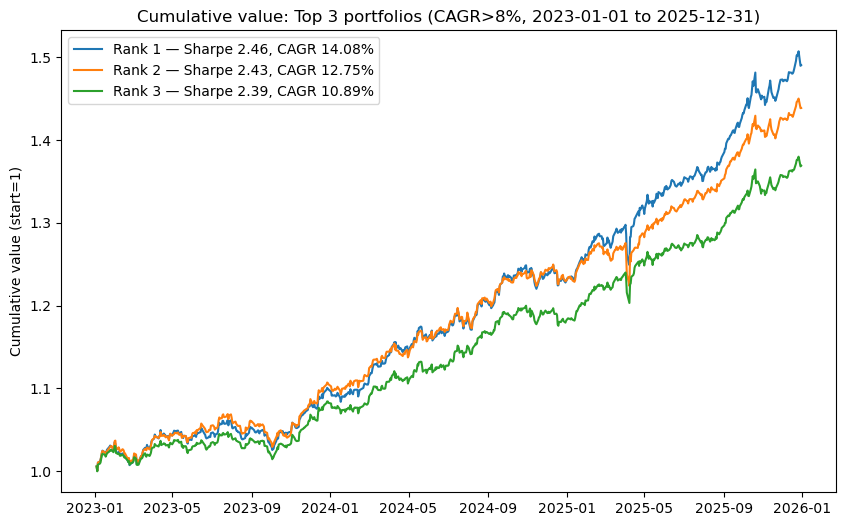

C:\Users\maxth\AppData\Local\Temp\ipykernel_41812\970118216.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(assets, rotation=45, ha='right')


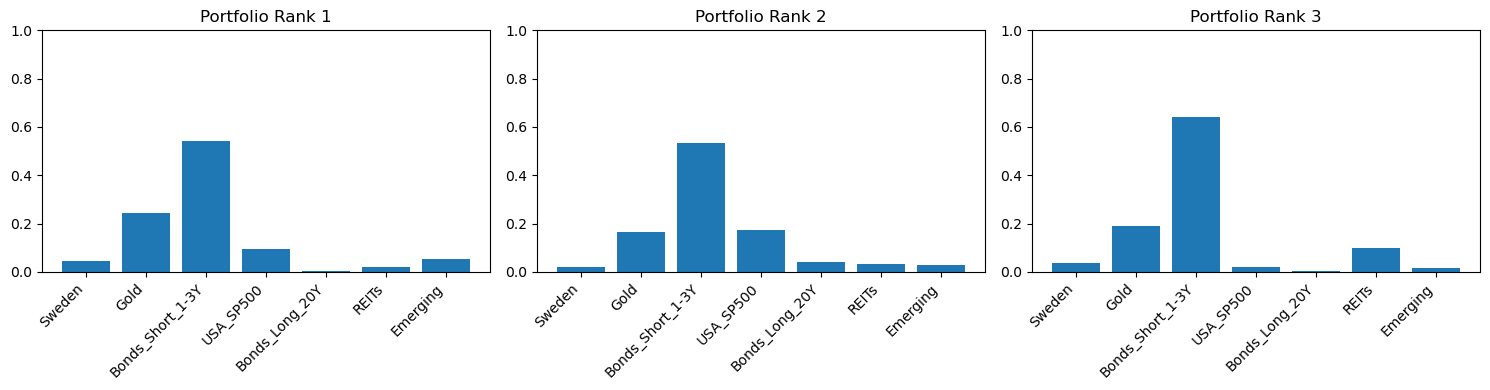

In [106]:
# Filter portfolios (CAGR > 6%) and visualize top 3 by Sharpe
import matplotlib.pyplot as plt

# Filter - adjust threshold based on period (use 8% for full period, 6% for 2007-2022)
cagr_threshold = 0.08  # Reduced threshold for 2007-2022 period which includes 2008 crisis
filtered = candidates[candidates['CAGR'] > cagr_threshold].copy()
filtered = filtered.sort_values('Sharpe', ascending=False)
print(f"Portfolios with CAGR>{cagr_threshold:.0%}: {len(filtered)}")
if len(filtered) == 0:
    print(f"No portfolios meet the CAGR>{cagr_threshold:.0%} threshold. Showing top 10 by Sharpe instead:")
    top3 = candidates.sort_values('Sharpe', ascending=False).head(3).reset_index(drop=True)
else:
    top3 = filtered.head(3).reset_index(drop=True)

display_cols = ['CAGR', 'AnnualVol', 'Sharpe', 'MaxDrawdown'] + [c for c in top3.columns if c.startswith('w_')]
display(top3[display_cols])

# Dynamic chart title based on START_DATE and END_DATE
date_range_str = f"{START_DATE} to {END_DATE}"

# cumulative returns plot for top 3
assets = list(net_returns.columns)
plt.figure(figsize=(10,6))
for i, row in top3.iterrows():
    weights = {asset: float(row[f'w_{asset}']) for asset in assets}
    p_rets = portfolio_return_series(net_returns, weights)
    vals = (1 + p_rets).cumprod()
    plt.plot(vals.index, vals, label=f"Rank {i+1} — Sharpe {row['Sharpe']:.2f}, CAGR {row['CAGR']:.2%}")
plt.legend()
plt.title(f'Cumulative value: Top 3 portfolios (CAGR>{cagr_threshold:.0%}, {date_range_str})')
plt.ylabel('Cumulative value (start=1)')
plt.show()

# weight bar charts
fig, axes = plt.subplots(1, min(3, len(top3)), figsize=(15,4))
if min(3, len(top3)) == 1:
    axes = [axes]
for i, row in top3.iterrows():
    w = [float(row[f'w_{asset}']) for asset in assets]
    ax = axes[i]
    ax.bar(assets, w)
    ax.set_title(f"Portfolio Rank {i+1}")
    ax.set_ylim(0,1)
    ax.set_xticklabels(assets, rotation=45, ha='right')
plt.tight_layout()
plt.show()

Takeaways
- V1: -> High Gold and High US and around 15-20% Bonds seems to create a good return/risk profile.
- V2 -> Still high gold, high US equities. Longer bonds. Low REIT and Emerging.
- V3 -> Test until end of 2022 to not include the gold rush. Includes 2 crisis, 2009 and 2020-2022 covid. Takeaway: lower gold but still high ~20%. Still high US equity and Long bonds.
- V4: 2010-2023. No gold! Or pretty low like 5%. Optimal mix seems to be between US eq and long bonds.
- V4 >10% CAGR. Very high US equities (65-80%), and mixing with either gold (15-20%) as a hedge, or REIT (10%), but for top 2 almost no REIT.

In [107]:
# Analyze contribution of each asset to portfolio returns for top 3 portfolios
print("=" * 80)
print("ASSET CLASS CONTRIBUTION TO TOTAL RETURN (Annualized CAGR)")
print("=" * 80)

for idx, row in top3.iterrows():
    print(f"\n{'='*80}")
    print(f"Portfolio Rank {idx + 1}")
    print(f"Overall CAGR: {row['CAGR']:.2%} | Sharpe: {row['Sharpe']:.2f} | Vol: {row['AnnualVol']:.2%}")
    print(f"{'='*80}")
    
    # Get weights for this portfolio
    weights = {asset: float(row[f'w_{asset}']) for asset in assets}
    
    # Calculate contribution of each asset
    contributions = {}
    for asset in assets:
        weight = weights[asset]
        asset_cagr = cagr_from_value_series((1 + net_returns[asset]).cumprod())
        contribution_to_return = asset_cagr * weight
        contributions[asset] = {
            'Weight': weight,
            'Asset_CAGR': asset_cagr,
            'Contribution': contribution_to_return
        }
    
    # Create DataFrame for this portfolio
    contrib_df = pd.DataFrame(contributions).T
    contrib_df = contrib_df.sort_values('Contribution', ascending=False)
    
    # Display
    print(f"{'Asset':<20} {'Weight':>10} {'Asset CAGR':>12} {'Contribution':>15}")
    print("-" * 60)
    for asset, row_data in contrib_df.iterrows():
        print(f"{asset:<20} {row_data['Weight']:>9.1%} {row_data['Asset_CAGR']:>11.2%} {row_data['Contribution']:>14.2%}")
    print("-" * 60)
    print(f"{'Total (Portfolio)':<20} {contrib_df['Weight'].sum():>9.1%} {'':>12} {contrib_df['Contribution'].sum():>14.2%}")
    print()


ASSET CLASS CONTRIBUTION TO TOTAL RETURN (Annualized CAGR)

Portfolio Rank 1
Overall CAGR: 14.08% | Sharpe: 2.46 | Vol: 5.52%
Asset                    Weight   Asset CAGR    Contribution
------------------------------------------------------------
Gold                     24.5%      31.83%          7.81%
Bonds_Short_1-3Y         54.2%       4.75%          2.57%
USA_SP500                 9.4%      23.03%          2.16%
Sweden                    4.4%      16.78%          0.73%
Emerging                  5.3%      13.30%          0.71%
REITs                     2.1%       5.94%          0.12%
Bonds_Long_20Y            0.1%      -1.51%         -0.00%
------------------------------------------------------------
Total (Portfolio)       100.0%                      14.11%


Portfolio Rank 2
Overall CAGR: 12.75% | Sharpe: 2.43 | Vol: 5.09%
Asset                    Weight   Asset CAGR    Contribution
------------------------------------------------------------
Gold                     16.7%      

In [108]:
# Show individual asset performance for the period
print("=" * 80)
print("INDIVIDUAL ASSET PERFORMANCE (2023-2025)")
print("=" * 80)
print(f"\nPeriod: {START_DATE} to {END_DATE}\n")

asset_perf = []
for asset in assets:
    asset_cagr = cagr_from_value_series((1 + net_returns[asset]).cumprod())
    asset_vol = annualized_vol(net_returns[asset])
    asset_sharpe = sharpe_ratio(net_returns[asset])
    
    # Calculate start and end prices
    start_price = prices[asset].iloc[0]
    end_price = prices[asset].iloc[-1]
    total_return = (end_price / start_price - 1)
    
    asset_perf.append({
        'Asset': asset,
        'CAGR': asset_cagr,
        'AnnualVol': asset_vol,
        'Sharpe': asset_sharpe,
        'Total_Return': total_return,
        'Start_Price': start_price,
        'End_Price': end_price
    })

perf_df = pd.DataFrame(asset_perf).sort_values('CAGR', ascending=False)

print(f"{'Asset':<20} {'CAGR':>10} {'Total Ret':>10} {'Vol':>10} {'Sharpe':>10}")
print("-" * 65)
for _, row in perf_df.iterrows():
    print(f"{row['Asset']:<20} {row['CAGR']:>9.2%} {row['Total_Return']:>9.2%} {row['AnnualVol']:>9.2%} {row['Sharpe']:>9.2f}")
print("=" * 80)


INDIVIDUAL ASSET PERFORMANCE (2023-2025)

Period: 2023-01-01 to 2025-12-31

Asset                      CAGR  Total Ret        Vol     Sharpe
-----------------------------------------------------------------
Gold                    31.83%   133.19%    16.34%      1.80
USA_SP500               23.03%    87.67%    15.35%      1.45
Sweden                  16.78%    63.30%    20.32%      0.90
Emerging                13.30%    50.29%    15.29%      0.95
REITs                    5.94%    21.92%    17.84%      0.46
Bonds_Short_1-3Y         4.75%    15.02%     0.27%     17.02
Bonds_Long_20Y          -1.51%    -2.56%    15.05%      0.00


In [73]:
# ISK tax example (simple annual tax at year-end)
start_value = 1.0
values = (1 + port_rets).cumprod() * start_value
tax_rate = 0.003  # example 0.3% annual schablon
values_after_tax = apply_isk_simple_tax_on_annual(values, tax_rate)
print('CAGR before tax:', cagr_from_value_series(values))
print('CAGR after tax:', cagr_from_value_series(values_after_tax))

CAGR before tax: 0.06718410370829098
CAGR after tax: 0.06511274973884218


In [94]:
# Save filtered/top3 if available
if 'top3' in globals():
    top3.to_csv(os.path.join(SAVE_DIR, 'top3_portfolios_v3.csv'), index=False)
    print(f"Saved top3 to {os.path.join(SAVE_DIR, 'top3_portfolios.csv')}")
else:
    print('`top3` not found in notebook globals — run the filter cell first.')

Saved top3 to results\top3_portfolios.csv


In [41]:
# Save candidate portfolios and top performers to disk
import os
candidates.to_csv(os.path.join(SAVE_DIR, 'candidates.csv'), index=False)
print(f"Saved candidates to {os.path.join(SAVE_DIR, 'candidates.csv')}")

# Save filtered/top3 if available
if 'top3' in globals():
    top3.to_csv(os.path.join(SAVE_DIR, 'top3_portfolios.csv'), index=False)
    print(f"Saved top3 to {os.path.join(SAVE_DIR, 'top3_portfolios.csv')}")
else:
    print('`top3` not found in notebook globals — run the filter cell first.')

# Save the price series used
prices.to_csv(os.path.join(SAVE_DIR, 'prices.csv'))
print(f"Saved prices to {os.path.join(SAVE_DIR, 'prices.csv')}")

# Optionally save the net_returns (returns after fees)
net_returns.to_csv(os.path.join(SAVE_DIR, 'net_returns.csv'))
print(f"Saved net_returns to {os.path.join(SAVE_DIR, 'net_returns.csv')}")

Saved candidates to results\candidates.csv
Saved top3 to results\top3_portfolios.csv
Saved prices to results\prices.csv
Saved net_returns to results\net_returns.csv


**Next steps**: add plotting, implement a proper ISK schablon calculation using the official formula (government rate + 1%), and add an optimizer to maximize Sharpe under constraints.